In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pymc as pm
import numpy as np
import pandas as pd

In [3]:
import bayesian_rainfall as br

In [4]:
data = br.model.load_data("data/noaa_historical_weather_eugene_or_2019-2024.csv")
data.head()

,DATE,PRCP,day_of_year
0,2019-01-01,0.0,1
1,2019-01-02,0.0,2
2,2019-01-03,0.0,3
3,2019-01-04,0.3,4
4,2019-01-05,4.6,5


In [5]:
model = br.model.create_rainfall_model(data)
model

         a_rain ~ Normal(0, 2)
         b_rain ~ Normal(0, 2)
         c_rain ~ Normal(0, 1)
       a_amount ~ Normal(0, 2)
       b_amount ~ Normal(0, 2)
       c_amount ~ Normal(1, 1)
   alpha_amount ~ Gamma(2, f())
         p_rain ~ Deterministic(f(b_rain, c_rain, a_rain))
 rain_indicator ~ Bernoulli(p_rain)
rainfall_amount ~ Gamma(alpha_amount, f(alpha_amount, b_amount, c_amount, a_amount))

In [6]:
trace = br.model.sample_model(model)
trace


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_rain, b_rain, c_rain, a_amount, b_amount, c_amount, alpha_amount]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [7]:
br.analysis.print_model_summary(trace, data)

=== MODEL SUMMARY ===
Total observations: 2192
Rainy days: 830
Overall rain frequency: 0.379
Mean rainfall on rainy days: 6.465 mm
Max rainfall: 59.400 mm

=== CONVERGENCE DIAGNOSTICS ===
R-hat values (should be < 1.01):
  a_rain: 1.0016
  b_rain: 1.0005
  c_rain: 0.9995
  a_amount: 1.0004
  b_amount: 0.9997
  c_amount: 1.0005
  alpha_amount: 1.0021

=== MODEL FIT ANALYSIS ===
Rain frequency - Observed: 0.379, Predicted: 0.379
Rain frequency error: 0.001 (0.1%)
Rainfall amount (rainy days) - Observed: 6.465, Predicted: 6.482
Rainfall amount error: 0.017 (0.3%)
Monthly rain frequency MAE: 0.059
Average prediction uncertainty (std): 0.016

Overall model fit quality: Excellent

=== SEASONAL PATTERNS ===
Peak rain probability: Day 24 (0.670)
Minimum rain probability: Day 207 (0.130)
Peak rainfall amount: Day 342 (7.769 mm)
Minimum rainfall amount: Day 159 (4.593 mm)


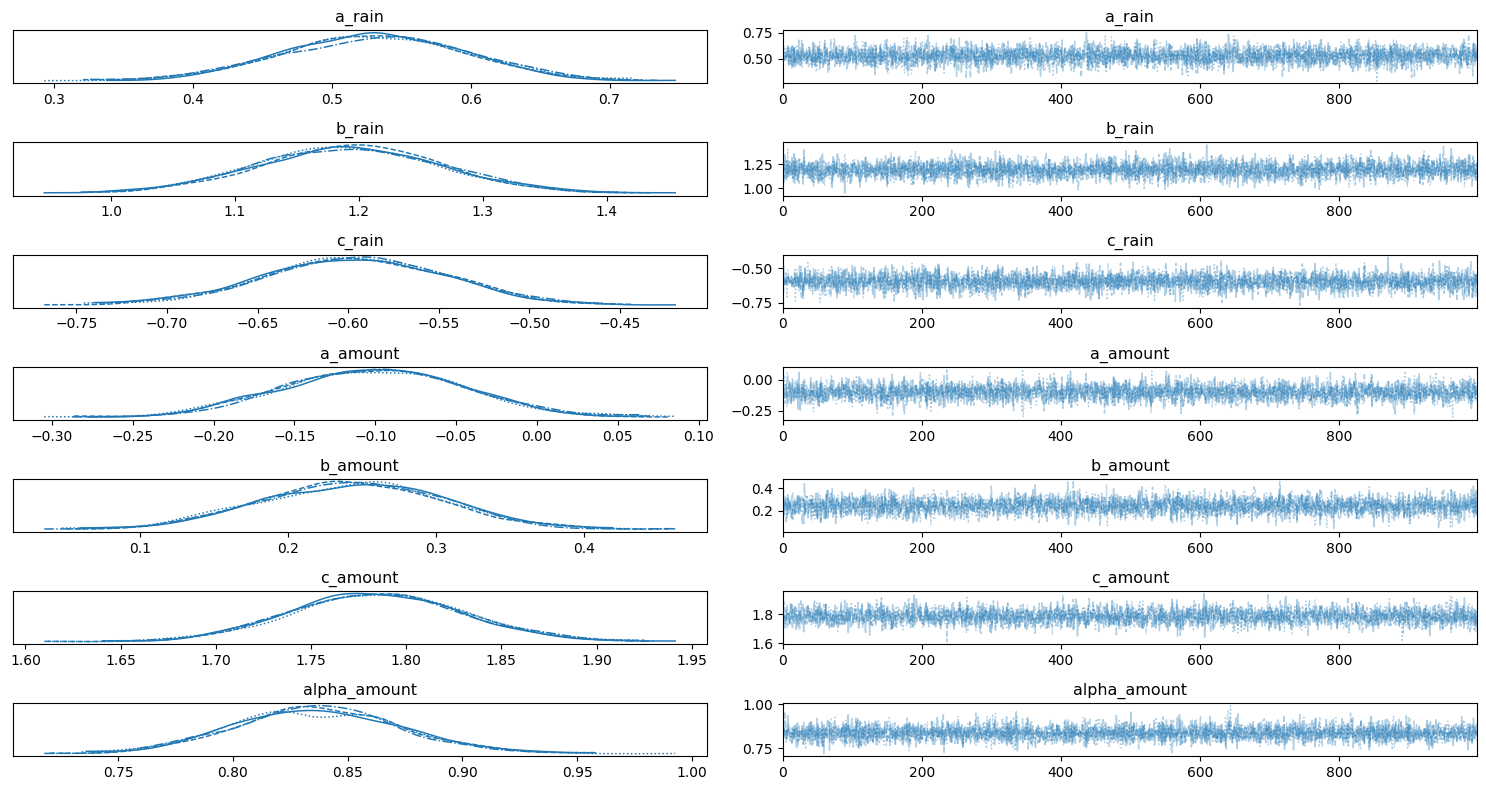

In [8]:
# Trace plots to check MCMC sampling
br.visualizations.plot_trace(trace)


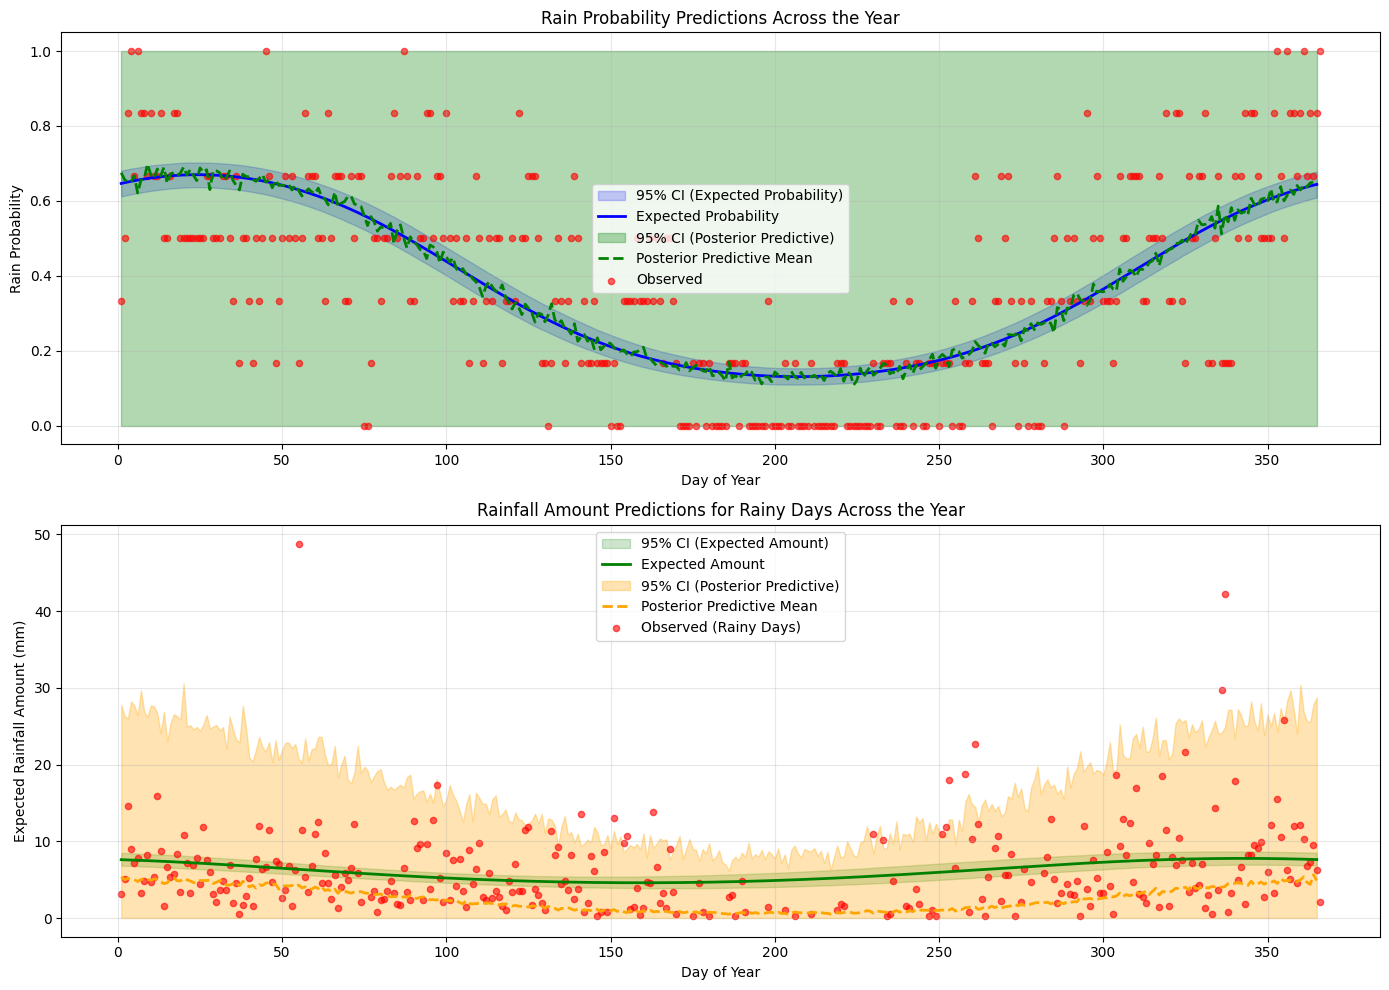

In [9]:
# Combined visualization: Rain probability and amount predictions with both CIs
br.visualizations.plot_combined_predictions(trace, data)


Sampling: [rain_indicator]


Output()

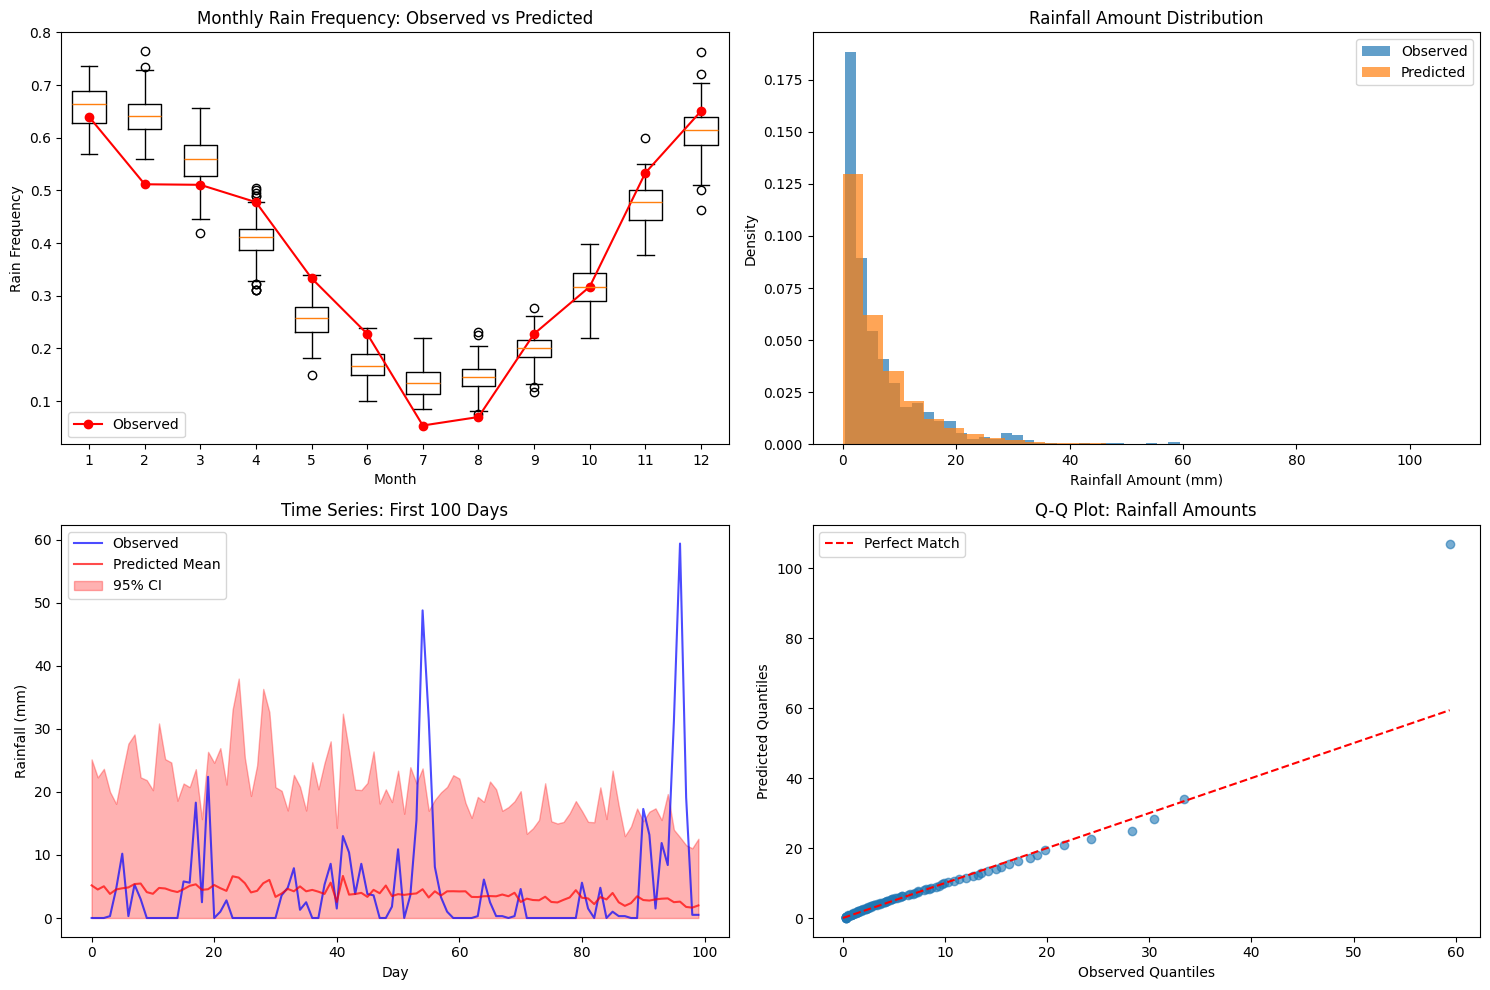

In [10]:
# Posterior predictive checks
br.visualizations.plot_posterior_predictive_checks(trace, model, data)


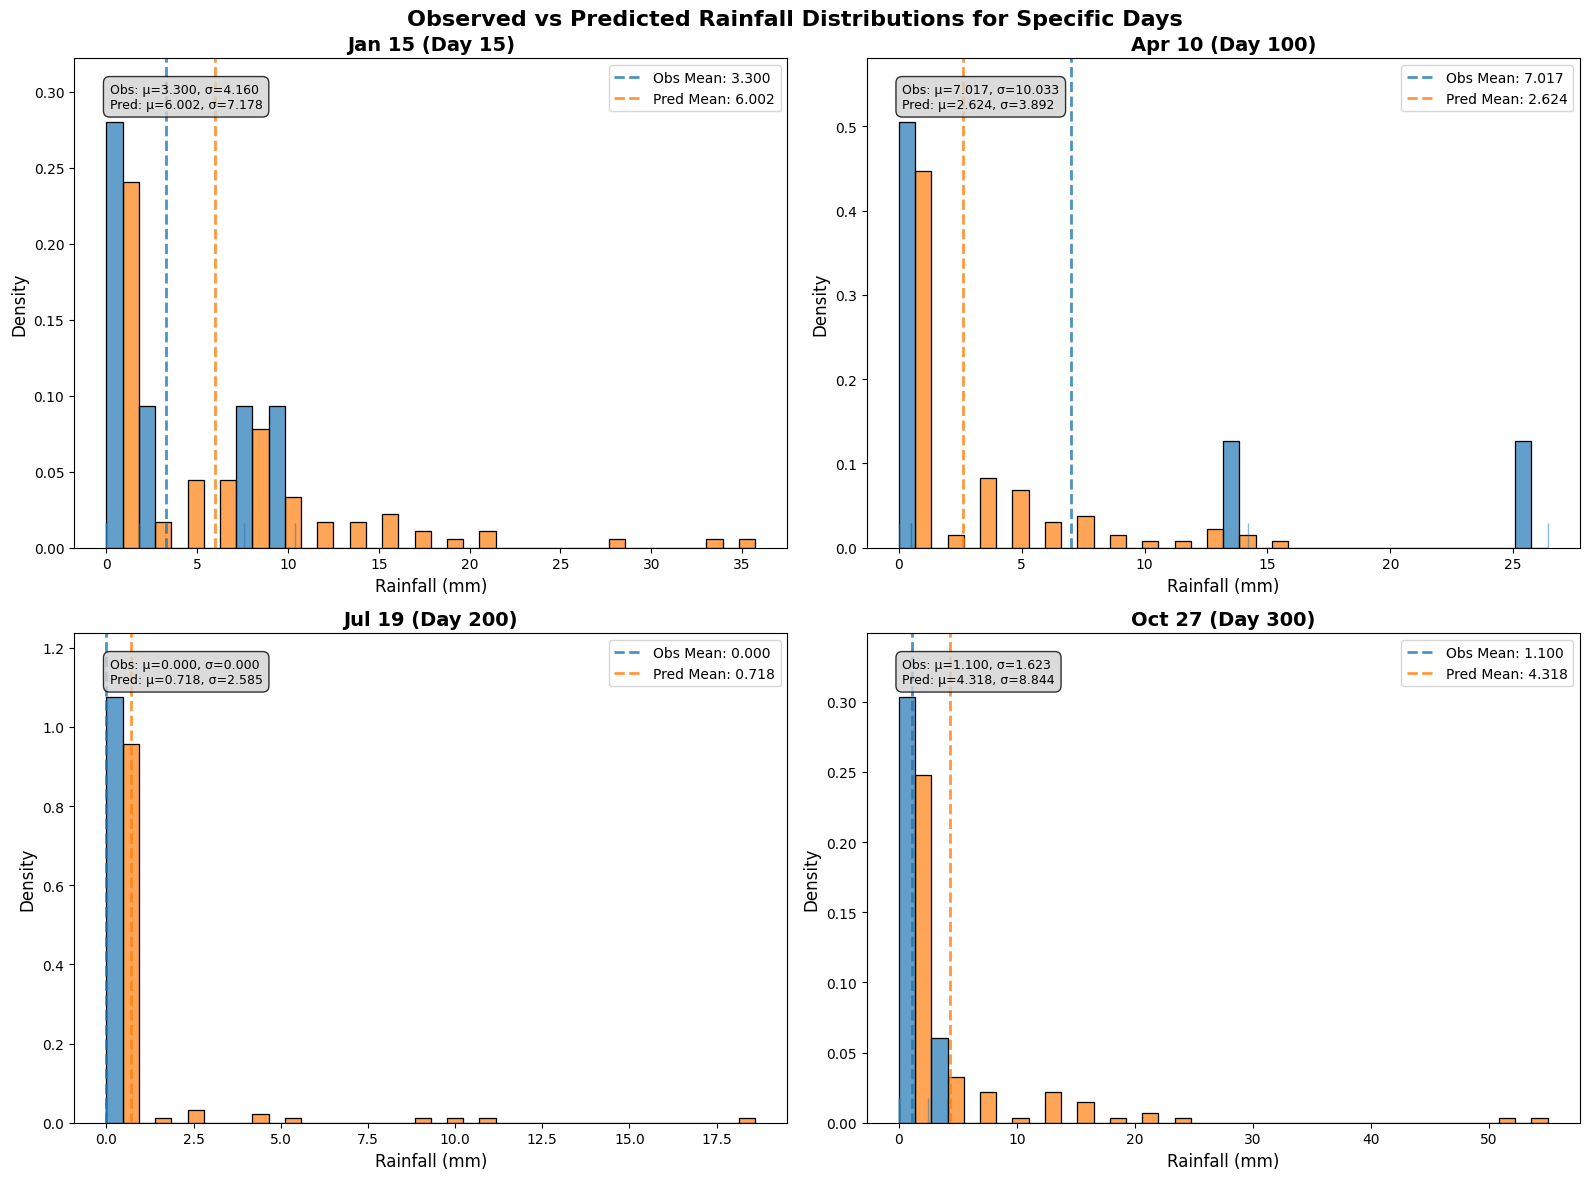

In [11]:
# Plot observed vs predicted rainfall distributions for specific days
br.visualizations.plot_specific_days_comparison(trace, data)

In [ ]:
# Seasonal comparison: Observed vs Predicted distributions by season
br.visualizations.plot_seasonal_summaries(trace, data)


# Single Day Analysis Examples

The following examples demonstrate the new single day analysis functions that provide comprehensive analysis of model predictions for specific days of the year.


=== ANALYSIS FOR JANUARY 15 (Day 15) ===

OBSERVED STATISTICS:
  Total observations: 6
  Rain frequency: 0.500 (50.0%)
  Mean rainfall: 3.3000 mm
  Median rainfall: 0.9000 mm
  Std deviation: 4.1597 mm
  Min rainfall: 0.0000 mm
  Max rainfall: 10.4000 mm
  Mean on rainy days: 6.6000 mm

PREDICTED STATISTICS:
  Rain probability: 0.666 ± 0.018
  Rain frequency: 0.669 (66.9%)
  Mean rainfall: 5.1047 mm
  Median rainfall: 1.8350 mm
  Std deviation: 7.5995 mm
  Min rainfall: 0.0000 mm
  Max rainfall: 70.3673 mm
  Mean on rainy days: 7.6303 mm

MODEL PERFORMANCE:
  Rain frequency error: 0.169 (33.8%)
  Mean rainfall error: 1.8047 mm (54.7%)

PREDICTION INTERVALS:
  Rainfall 95% CI: [0.0000, 26.1215] mm
  Rainfall 90% CI: [0.0000, 20.0356] mm
  Rainfall 50% CI: [0.0000, 7.5063] mm
  Rain probability 95% CI: [0.633, 0.698]


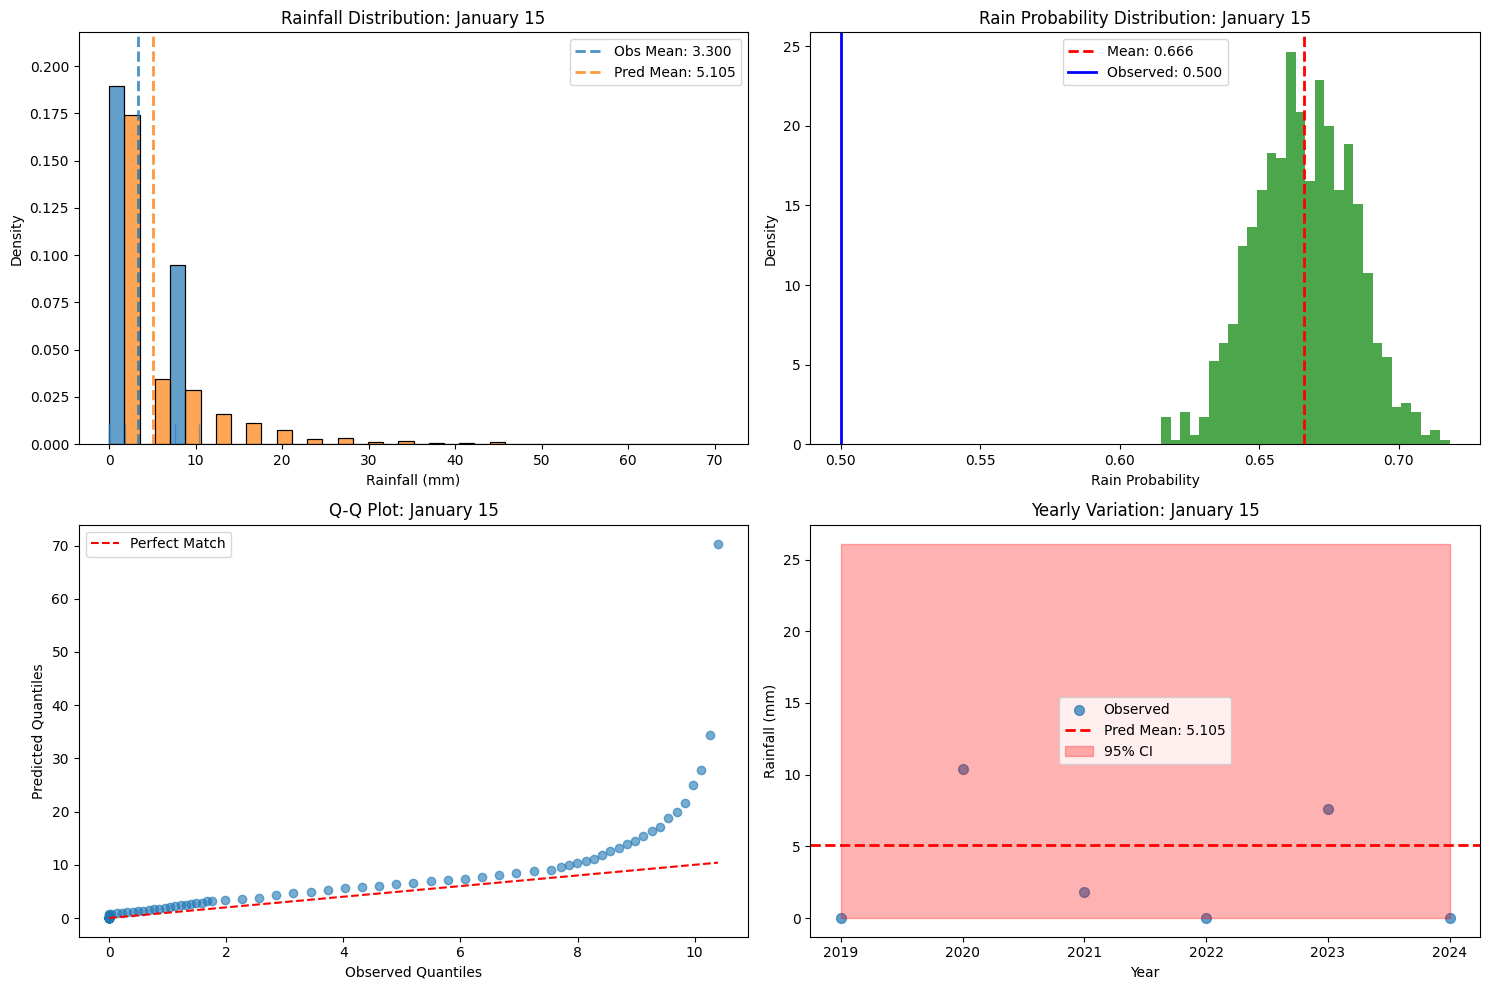

In [ ]:
# Example 1: Comprehensive analysis for a specific day
# You can specify the date in multiple ways:
# - Day of year: 15 (January 15)
# - String format: "01/15" 
# - Tuple format: (1, 15)

# Using day of year
results_jan15 = br.analysis.analyze_single_day(
    trace=trace, 
    data=data, 
    date_input=15,  # Day 15 (January 15)
    show_plots=True
)


=== ANALYSIS FOR SEPTEMBER 14 (Day 258) ===

OBSERVED STATISTICS:
  Total observations: 6
  Rain frequency: 0.167 (16.7%)
  Mean rainfall: 3.1333 mm
  Median rainfall: 0.0000 mm
  Std deviation: 7.0063 mm
  Min rainfall: 0.0000 mm
  Max rainfall: 18.8000 mm
  Mean on rainy days: 18.8000 mm

PREDICTED STATISTICS:
  Rain probability: 0.193 ± 0.014
  Rain frequency: 0.176 (17.6%)
  Mean rainfall: 1.1226 mm
  Median rainfall: 0.0000 mm
  Std deviation: 3.8625 mm
  Min rainfall: 0.0000 mm
  Max rainfall: 42.8690 mm
  Mean on rainy days: 6.3784 mm

MODEL PERFORMANCE:
  Rain frequency error: 0.009 (5.6%)
  Mean rainfall error: 2.0107 mm (64.2%)

PREDICTION INTERVALS:
  Rainfall 95% CI: [0.0000, 13.3020] mm
  Rainfall 90% CI: [0.0000, 8.2717] mm
  Rainfall 50% CI: [0.0000, 0.0000] mm
  Rain probability 95% CI: [0.166, 0.220]


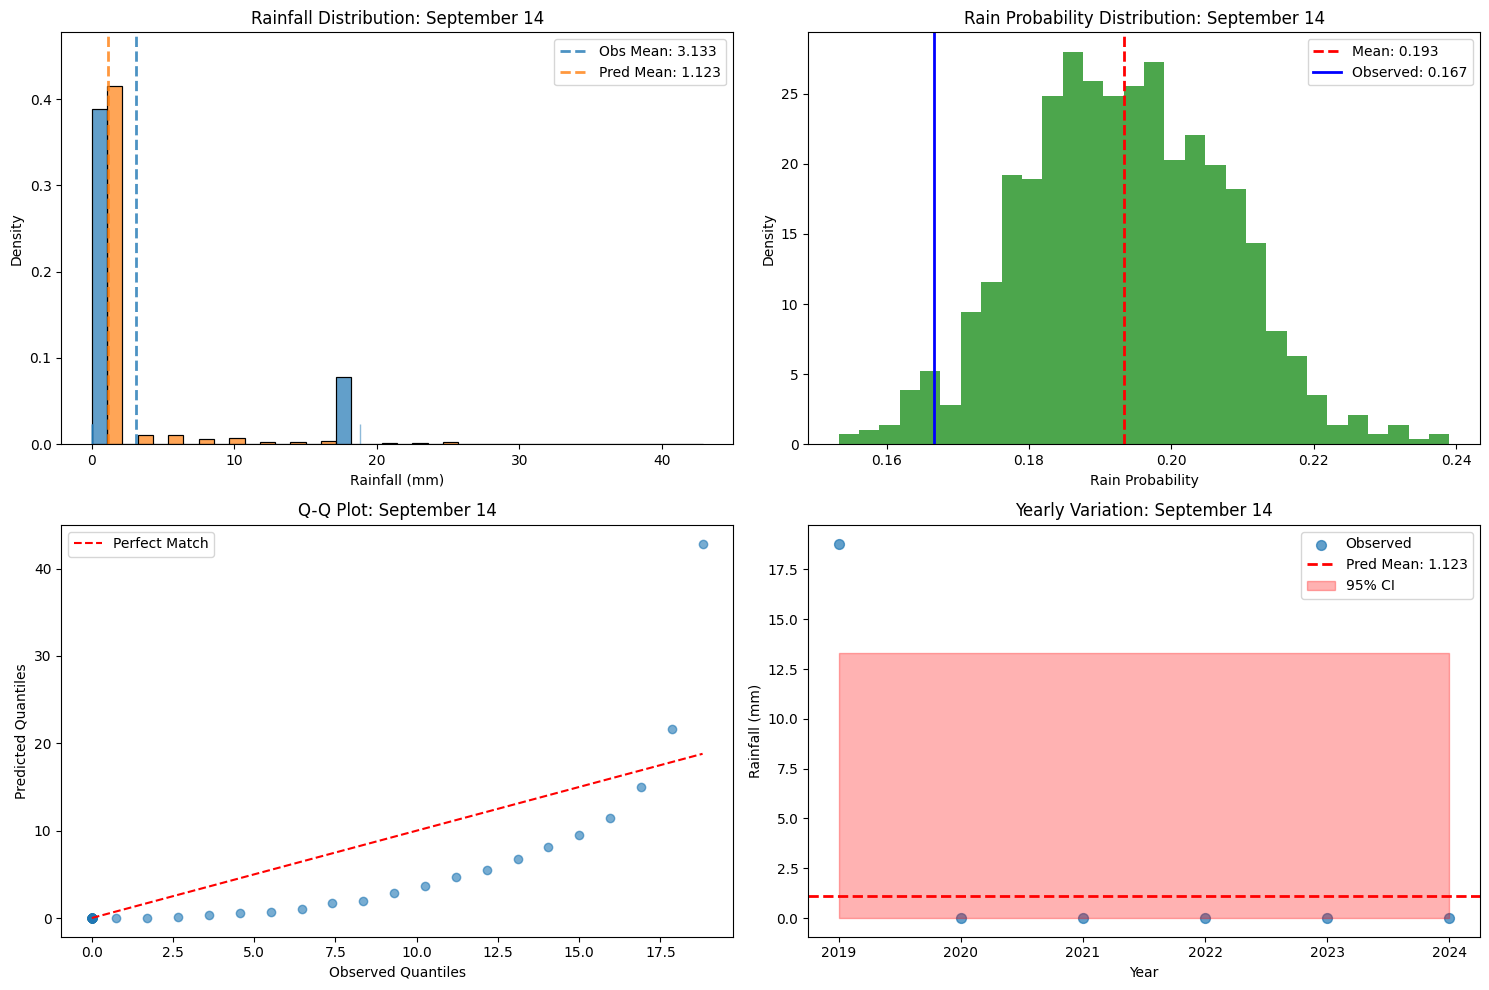

In [ ]:
# Example 2: Analysis using string format (July 15)
# Summer days typically have lower rain probability
results_jul15 = br.analysis.analyze_single_day(
    trace=trace, 
    data=data, 
    date_input="09/14",  # July 15
    show_plots=True
)


## Probability Analysis Examples

These functions allow you to calculate specific probabilities for rainfall events on given days.


In [ ]:
# Example 3: Calculate probability of any rain on a given day
# This is useful for planning outdoor activities
# Using tuple format (month, day)
any_rain_prob = br.analysis.print_any_rain_probability(
    trace=trace, 
    date_input="09/14"
)


=== ANY RAIN PROBABILITY ANALYSIS ===
Date: September 14 (Day 258)
Probability of any rain: 0.193 ± 0.014
95% CI: [0.166, 0.220]
90% CI: [0.171, 0.216]
50% CI: [0.184, 0.204]


In [ ]:
# Example 4: Calculate probability of rainfall within various intervals
# This is useful for agricultural planning or flood risk assessment

# Any rainfall (no bounds) - equivalent to calculate_any_rain_probability
any_rainfall_prob = br.analysis.print_rainfall_interval_probability(
    trace=trace, 
    date_input="09/14",
    interval_min=1.0,
    # interval_max=3.0,
)


=== RAINFALL INTERVAL PROBABILITY ANALYSIS ===
Date: September 14 (Day 258)
Interval: ≥ 1.000 mm
Probability of rainfall in interval: 0.156 (15.6%)
95% CI for probability: [0.135, 0.180]


In [ ]:
# Example usage:
br.analysis.print_simple_daily_rainfall_analysis(trace, date_input="09/14")


INTERVAL PROBABILITY EXAMPLES
Date analyzed: 09/14

Any rainfall: 0.179 ± 0.024

Negligible rain (<0.1 mm): 0.816 ± 0.024
Light rain (0.1–2.5 mm): 0.072 ± 0.016
Moderate rain (2.5–10 mm): 0.088 ± 0.018
Heavy rain (>10 mm): 0.042 ± 0.012

Note: These should sum to 1.0 (with some rounding error)
Sum: 1.018

Confidence intervals reflect uncertainty in the probability estimates due to parameter uncertainty.


In [ ]:
type(trace)

arviz.data.inference_data.InferenceData

In [ ]:
# Example 5: Compare different days of the year
# Let's analyze a few different days to see seasonal patterns
# Mix of different input formats to show flexibility

days_to_analyze = [
    15,           # day of year (January 15)
    "04/10",      # string format (April 10)
    (7, 19),      # tuple format (July 19)
    300           # day of year (October 27)
]

print("SEASONAL COMPARISON OF RAIN PROBABILITIES")
print("=" * 60)

for date_input in days_to_analyze:
    rain_prob = br.analysis.calculate_any_rain_probability(trace, date_input)
    print(f"{rain_prob['day_name']:25} | P(rain) = {rain_prob['mean_probability']:.3f} ± {rain_prob['std_probability']:.3f}")


SEASONAL COMPARISON OF RAIN PROBABILITIES
=== ANY RAIN PROBABILITY ANALYSIS ===
Date: January 15 (Day 15)
Probability of any rain: 0.666 ± 0.018
95% CI: [0.633, 0.698]
90% CI: [0.637, 0.694]
50% CI: [0.654, 0.679]
January 15                | P(rain) = 0.666 ± 0.018
=== ANY RAIN PROBABILITY ANALYSIS ===
Date: April 10 (Day 101)
Probability of any rain: 0.432 ± 0.019
95% CI: [0.396, 0.467]
90% CI: [0.402, 0.462]
50% CI: [0.419, 0.445]
April 10                  | P(rain) = 0.432 ± 0.019
=== ANY RAIN PROBABILITY ANALYSIS ===
Date: July 19 (Day 201)
Probability of any rain: 0.131 ± 0.012
95% CI: [0.110, 0.154]
90% CI: [0.112, 0.151]
50% CI: [0.123, 0.138]
July 19                   | P(rain) = 0.131 ± 0.012
=== ANY RAIN PROBABILITY ANALYSIS ===
Date: October 26 (Day 300)
Probability of any rain: 0.364 ± 0.018
95% CI: [0.327, 0.399]
90% CI: [0.335, 0.394]
50% CI: [0.351, 0.377]
October 26                | P(rain) = 0.364 ± 0.018


# Weekly Rain Probability Analysis

This section shows the chance of any rain each week throughout the year, providing a more granular view of seasonal patterns than monthly analysis.


In [ ]:
# Plot weekly rain probability throughout the year
weekly_results = br.visualizations.plot_weekly_rain_probability(trace, data)


NameError: name '_evaluate_model_for_day' is not defined